In [2]:
import numpy as np
import pickle
import math
from scipy.stats import sem
import matplotlib.pyplot as plt
import pandas as pd
import time
import pprint
import seaborn as sns
import statsmodels.formula.api as smf
import analysis_utils as au
from matplotlib.lines import Line2D
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
SAVEFIG = False

### Data Preparation and Preprocessing

In [3]:
# import dataframe with both real data and simulation data
with open("simu1_data/simu1_behav.pkl", 'rb') as inp:
    df = pickle.load(inp)
df

,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,NaN,0,53,0
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,NaN,0,26,0
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,NaN,0,33,0
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,NaN,1,151,0
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,NaN,0,187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350
203576,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350
203577,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350
203578,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350


In [4]:
# calculate the rolling category length
rolling_window = 9
category_label_dummies = df['category_label'].str.get_dummies()
category_label_dummies.columns = ['cl_' + col for col in category_label_dummies.columns]
category_label_dummies_events = pd.concat([df, category_label_dummies], axis=1) # record the occurrence of every cat label
cl_rolling_sum = category_label_dummies_events.groupby('subject_ID').rolling(rolling_window, min_periods=1, on='position')[category_label_dummies.columns].sum().reset_index()
df_rollcat = df.merge(cl_rolling_sum, on=['subject_ID', 'position'])
df['roll_cat_label_length'] = df_rollcat.apply(lambda x: x['cl_' + x['category_label']], axis = 1) # how many cat within 10 window
df['roll_cat_label_length'] = df['roll_cat_label_length'] - 1 # how many cat in previous 9 window. not include self

# add rolling category length level
# option = "0-1-2+"
option = "0+1-2+"
# option = "0-1+"
if option == "0-1-2+":
    # option 0: 0, 1, >=2
    df['roll_cat_len_level']= pd.cut(x=df.roll_cat_label_length, 
                                    bins=[0, 1, 2, np.inf], right=False, include_lowest = True,
                                    labels=['0', '1', '>=2']).astype('str')
elif option == "0+1-2+":
    # option 1: 0-1, >=2
    df['roll_cat_len_level']= pd.cut(x=df.roll_cat_label_length, 
                                    bins=[0, 2, np.inf], right=False, include_lowest = True,
                                    labels=['0-1', '>=2']).astype('str')
elif option == "0-1+":
    # option 2: 0, >=1
    df['roll_cat_len_level']= pd.cut(x=df.roll_cat_label_length, 
                                    bins=[0, 1, np.inf], right=False, include_lowest = True,
                                    labels=['0', '>=1']).astype('str')
df

,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session,roll_cat_label_length,roll_cat_len_level
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,NaN,0,53,0,0.0,0-1
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,NaN,0,26,0,0.0,0-1
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,NaN,0,33,0,0.0,0-1
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,NaN,1,151,0,1.0,0-1
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,NaN,0,187,0,0.0,0-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350,2.0,>=2
203576,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350,0.0,0-1
203577,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350,3.0,>=2
203578,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350,0.0,0-1


In [5]:
# add log and log lag bin
df['log_lag'] = np.log(df['lag'])
df['log_lag_bin'] = pd.cut(df['log_lag'], np.arange(df['log_lag'].max()+1), labels=False, right=False)
df

/Users/bei/anaconda3/envs/cmr/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session,roll_cat_label_length,roll_cat_len_level,log_lag,log_lag_bin
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,NaN,0,53,0,0.0,0-1,-inf,NaN
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,NaN,0,26,0,0.0,0-1,-inf,NaN
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,NaN,0,33,0,0.0,0-1,-inf,NaN
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,NaN,1,151,0,1.0,0-1,-inf,NaN
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,NaN,0,187,0,0.0,0-1,-inf,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350,2.0,>=2,3.610918,3.0
203576,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350,0.0,0-1,4.744932,4.0
203577,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350,3.0,>=2,3.178054,3.0
203578,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350,0.0,0-1,3.713572,3.0


In [6]:
# construct local FAR
# for i in range(1, len(df)):
#     if df.loc[i, 'old'] == False and df.loc[i-1, 'old'] == True:
#         df.loc[i, 'log_lag_bin'] = df.loc[i-1, 'log_lag_bin']
old_vec = df.old.to_numpy()
log_lag_bin_vec = df.log_lag_bin.to_numpy()
position_vec = df.position.to_numpy()
log_lag_bin_newpre_lst = []
log_lag_bin_newpost_lst = []
for i in range(len(df)):
    if position_vec[i] > 0:
        if old_vec[i] == False and old_vec[i-1] == True:
            log_lag_bin_newpre_lst.append(log_lag_bin_vec[i-1])
        else:
            log_lag_bin_newpre_lst.append('N')
    else:
        log_lag_bin_newpre_lst.append('N')

    if position_vec[i] < np.max(position_vec):
        if old_vec[i] == False and old_vec[i+1] == True:
            log_lag_bin_newpost_lst.append(log_lag_bin_vec[i+1])
        else:
            log_lag_bin_newpost_lst.append('N')
    else:
        log_lag_bin_newpost_lst.append('N')

df['log_lag_bin_newpre'] = log_lag_bin_newpre_lst
df['log_lag_bin_newpost'] = log_lag_bin_newpost_lst
df

,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,curr_cat_length,curr_cat_label_length,itemno,session,roll_cat_label_length,roll_cat_len_level,log_lag,log_lag_bin,log_lag_bin_newpre,log_lag_bin_newpost
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,NaN,0,53,0,0.0,0-1,-inf,NaN,N,N
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,NaN,0,26,0,0.0,0-1,-inf,NaN,N,N
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,NaN,0,33,0,0.0,0-1,-inf,NaN,N,N
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,NaN,1,151,0,1.0,0-1,-inf,NaN,N,N
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,NaN,0,187,0,0.0,0-1,-inf,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,18.0,18,60,350,2.0,>=2,3.610918,3.0,N,N
203576,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,23.0,23,10,350,0.0,0-1,4.744932,4.0,N,N
203577,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,19.0,19,265,350,3.0,>=2,3.178054,3.0,N,N
203578,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,NaN,23,213,350,0.0,0-1,3.713572,3.0,N,N


In [7]:
df['log_lag_bin'] = df.apply(lambda x: 0 if x['log_lag_bin'] == 1 else x['log_lag_bin'], axis = 1)
df['log_lag_bin_newpre'] = df.apply(lambda x: 0 if x['log_lag_bin_newpre'] == 1 else x['log_lag_bin_newpre'], axis = 1)
df['log_lag_bin_newpost'] = df.apply(lambda x: 0 if x['log_lag_bin_newpost'] == 1 else x['log_lag_bin_newpost'], axis = 1)
# distribute items into bins
log_lag_bins = [0, 2, 3, 4, 5]
for bin in log_lag_bins:
    col_name = "log_lag_bin_" + str(bin)
    df[col_name] = (df.log_lag_bin == bin) | (df.log_lag_bin_newpre == bin) | (df.log_lag_bin_newpost == bin)
df

,rt,subject_ID,item,lag,category,confidence,category_label,position,old,yes,...,roll_cat_len_level,log_lag,log_lag_bin,log_lag_bin_newpre,log_lag_bin_newpost,log_lag_bin_0,log_lag_bin_2,log_lag_bin_3,log_lag_bin_4,log_lag_bin_5
0,1514.875,0,CHICKEN,0,Uncategorized,1.0,FarmAnimals,0,False,0,...,0-1,-inf,NaN,N,N,False,False,False,False,False
1,853.505,0,BLUEBERRY,0,Uncategorized,1.0,Fruit,1,False,0,...,0-1,-inf,NaN,N,N,False,False,False,False,False
2,731.040,0,BUS,0,Uncategorized,1.0,Vehicles,2,False,0,...,0-1,-inf,NaN,N,N,False,False,False,False,False
3,848.955,0,LEMON,0,Uncategorized,1.0,Fruit,3,False,0,...,0-1,-inf,NaN,N,N,False,False,False,False,False
4,643.880,0,OYSTER,0,Uncategorized,1.0,OceanAnimals,4,False,0,...,0-1,-inf,NaN,N,N,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203575,1911.000,656,COLA,37,Beverages,2.0,Beverages,575,True,0,...,>=2,3.610918,3.0,N,N,False,False,True,False,False
203576,2358.000,656,BASEBALL,115,Toys,8.0,Toys,576,True,1,...,0-1,4.744932,4.0,N,N,False,False,False,True,False
203577,1239.000,656,TEA,24,Beverages,8.0,Beverages,577,True,1,...,>=2,3.178054,3.0,N,N,False,False,True,False,False
203578,1567.000,656,RADIO,41,Uncategorized-Singleton,2.0,Electronics,578,True,0,...,0-1,3.713572,3.0,N,N,False,False,True,False,False


In [8]:
# # clean out NA resp
# df = df.loc[pd.notna(df.yes)].reset_index(drop=True)
# df = df.astype({'yes': 'int32'})
# df

In [9]:
# # deal with old items
# df_old = df.query("old == True").copy()
# df_old['log_lag_bin'] = df_old.apply(lambda x: 0 if x['log_lag_bin'] == 1 else x['log_lag_bin'], axis = 1)
# df_old

In [10]:
# # deal with new items
# df_new = df.query("old == False").copy()

# # combine bin 0 and 1
# df_new['log_lag_bin_newpre'] = df_new.apply(lambda x: 0 if x['log_lag_bin_newpre'] == 1 else x['log_lag_bin_newpre'], axis = 1)
# df_new['log_lag_bin_newpost'] = df_new.apply(lambda x: 0 if x['log_lag_bin_newpost'] == 1 else x['log_lag_bin_newpost'], axis = 1)

# # distribute items into bins
# log_lag_bins = [0, 2, 3, 4, 5]
# for bin in log_lag_bins:
#     col_name = "log_lag_bin_" + str(bin)
#     df_new[col_name] = (df_new.log_lag_bin_newpre == bin) | (df_new.log_lag_bin_newpost == bin)
# df_new

### Hit Recency with Rolling Category Length Level

In [11]:
# df_old.groupby("log_lag_bin").yes.count()

In [12]:
# df_old.groupby("roll_cat_len_level").yes.count()

In [13]:
df.groupby(["old", "log_lag_bin", "roll_cat_len_level"]).yes.count()

old   log_lag_bin  roll_cat_len_level
True  0.0          0-1                    6285
                   >=2                   12493
      2.0          0-1                   15794
                   >=2                    5986
      3.0          0-1                   26019
                   >=2                    2843
      4.0          0-1                   19483
                   >=2                    1212
      5.0          0-1                    4268
                   >=2                     196
      6.0          0-1                      43
Name: yes, dtype: Int64

#### Lag Group and Roll Cat

In [14]:
# # mean of log bin for every subject
# df_5 = df_old.query('log_lag_bin <= 5')

# # count and add 0.5 / 1 to numerator / denominator, to avoid 0 and 1
# df_rollcat_laggp_old = df_5.groupby(['subject_ID','old','roll_cat_len_level','log_lag_bin'])['yes'].agg(['mean', 'sum', 'count']).reset_index()
# df_rollcat_laggp_old.rename(columns={'mean': 'yes_rate'}, inplace=True)
# df_rollcat_laggp_old['yes_rate_adj'] = (df_rollcat_laggp_old['sum'] + 0.5) / (df_rollcat_laggp_old['count'] + 1)
# df_rollcat_laggp_old

In [15]:
# # calculate rollcat laggp for new items
# df_lst = []
# for bin in log_lag_bins:
#     col_name = "log_lag_bin_" + str(bin)
#     df_tmp = df_new.query(col_name + " == True").groupby(["subject_ID", "old", "roll_cat_len_level"])['yes'].agg(['mean', 'sum', 'count']).reset_index()
#     df_tmp["log_lag_bin"] = bin
#     df_lst.append(df_tmp)
# df_rollcat_laggp_new = pd.concat(df_lst)
# df_rollcat_laggp_new.rename(columns={'mean': 'yes_rate'}, inplace=True)
# df_rollcat_laggp_new['yes_rate_adj'] = (df_rollcat_laggp_new['sum'] + 0.5) / (df_rollcat_laggp_new['count'] + 1)
# df_rollcat_laggp_new

In [16]:
# # combine old and new
# df_rollcat_laggp = pd.concat([df_rollcat_laggp_old, df_rollcat_laggp_new]).reset_index(drop=True)

In [17]:
df_lst = []
for bin in log_lag_bins:
    col_name = "log_lag_bin_" + str(bin)
    df_tmp = df.query(col_name + " == True").groupby(["subject_ID", "old", "roll_cat_len_level"])['yes'].agg(['mean', 'sum', 'count']).reset_index()
    df_tmp["log_lag_bin"] = bin
    df_lst.append(df_tmp)
df_rollcat_laggp = pd.concat(df_lst)
df_rollcat_laggp.rename(columns={'mean': 'yes_rate'}, inplace=True)
df_rollcat_laggp['yes_rate_adj'] = (df_rollcat_laggp['sum'] + 0.5) / (df_rollcat_laggp['count'] + 1)
df_rollcat_laggp

,subject_ID,old,roll_cat_len_level,yes_rate,sum,count,log_lag_bin,yes_rate_adj
0,0,False,0-1,0.241379,14,58,0,0.245763
1,0,False,>=2,0.285714,14,49,0,0.29
2,0,True,0-1,0.971429,34,35,0,0.958333
3,0,True,>=2,1.0,86,86,0,0.994253
4,1,False,0-1,0.130435,3,23,0,0.145833
...,...,...,...,...,...,...,...,...
923,655,True,>=2,0.0,0,1,5,0.25
924,656,False,0-1,0.285714,2,7,5,0.3125
925,656,False,>=2,0.0,0,5,5,0.083333
926,656,True,0-1,0.727273,8,11,5,0.708333


In [18]:
# log lag for display
df_rollcat_laggp['log_lag_disp'] = np.ceil(np.e**df_rollcat_laggp.log_lag_bin)
df_rollcat_laggp

,subject_ID,old,roll_cat_len_level,yes_rate,sum,count,log_lag_bin,yes_rate_adj,log_lag_disp
0,0,False,0-1,0.241379,14,58,0,0.245763,1.0
1,0,False,>=2,0.285714,14,49,0,0.29,1.0
2,0,True,0-1,0.971429,34,35,0,0.958333,1.0
3,0,True,>=2,1.0,86,86,0,0.994253,1.0
4,1,False,0-1,0.130435,3,23,0,0.145833,1.0
...,...,...,...,...,...,...,...,...,...
923,655,True,>=2,0.0,0,1,5,0.25,149.0
924,656,False,0-1,0.285714,2,7,5,0.3125,149.0
925,656,False,>=2,0.0,0,5,5,0.083333,149.0
926,656,True,0-1,0.727273,8,11,5,0.708333,149.0


In [19]:
df_rollcat_laggp.groupby(["old", "log_lag_bin", "roll_cat_len_level"])['count'].sum()

old    log_lag_bin  roll_cat_len_level
False  0            0-1                   12160
                    >=2                    7444
       2            0-1                   13422
                    >=2                    6844
       3            0-1                   17190
                    >=2                    8350
       4            0-1                   11761
                    >=2                    6146
       5            0-1                    2310
                    >=2                    1284
True   0            0-1                    6285
                    >=2                   12493
       2            0-1                   15794
                    >=2                    5986
       3            0-1                   26019
                    >=2                    2843
       4            0-1                   19483
                    >=2                    1212
       5            0-1                    4268
                    >=2                     196
N

In [20]:
# pivot for hr and far
df_rollcat_laggp['old'] = df_rollcat_laggp['old'].astype('str')
df_dprime = pd.pivot_table(df_rollcat_laggp, values=['yes_rate', 'yes_rate_adj'], index=['subject_ID', 'roll_cat_len_level', 'log_lag_disp'], columns='old').reset_index()
df_dprime.columns = [' '.join(col).strip() for col in df_dprime.columns.values]
df_dprime = df_dprime.rename(columns={'yes_rate False': 'far', 'yes_rate True': 'hr', 'yes_rate_adj False': 'far_adj', 'yes_rate_adj True': 'hr_adj'})

# df_dprime = au.loftus_masson(df_dprime, 'subject_ID', ['roll_cat_len_level', 'log_lag_disp'], 'hr') - previous wrong!!
df_dprime

,subject_ID,roll_cat_len_level,log_lag_disp,far,hr,far_adj,hr_adj
0,0,0-1,1.0,0.241379,0.971429,0.245763,0.958333
1,0,0-1,8.0,0.264706,0.953488,0.271429,0.943182
2,0,0-1,21.0,0.292683,0.983051,0.297619,0.975
3,0,0-1,55.0,0.190476,0.931034,0.204545,0.916667
4,0,>=2,1.0,0.285714,1.0,0.29,0.994253
...,...,...,...,...,...,...,...
3353,656,>=2,1.0,0.117647,0.894737,0.138889,0.875
3354,656,>=2,8.0,0.375,1.0,0.382353,0.916667
3355,656,>=2,21.0,0.15625,0.777778,0.166667,0.75
3356,656,>=2,55.0,0.117647,0.6,0.128571,0.583333


In [21]:
# calculate dprime
df_dprime['z_hr'] = norm.ppf(df_dprime['hr_adj'])
df_dprime['z_far'] = norm.ppf(df_dprime['far_adj'])
df_dprime['dprime'] = df_dprime['z_hr'] - df_dprime['z_far']
df_dprime

,subject_ID,roll_cat_len_level,log_lag_disp,far,hr,far_adj,hr_adj,z_hr,z_far,dprime
0,0,0-1,1.0,0.241379,0.971429,0.245763,0.958333,1.731664,-0.687885,2.419549
1,0,0-1,8.0,0.264706,0.953488,0.271429,0.943182,1.582058,-0.608498,2.190556
2,0,0-1,21.0,0.292683,0.983051,0.297619,0.975,1.959964,-0.531261,2.491225
3,0,0-1,55.0,0.190476,0.931034,0.204545,0.916667,1.382994,-0.825494,2.208489
4,0,>=2,1.0,0.285714,1.0,0.29,0.994253,2.527302,-0.553385,3.080687
...,...,...,...,...,...,...,...,...,...,...
3353,656,>=2,1.0,0.117647,0.894737,0.138889,0.875,1.150349,-1.085325,2.235674
3354,656,>=2,8.0,0.375,1.0,0.382353,0.916667,1.382994,-0.299307,1.682301
3355,656,>=2,21.0,0.15625,0.777778,0.166667,0.75,0.674490,-0.967422,1.641911
3356,656,>=2,55.0,0.117647,0.6,0.128571,0.583333,0.210428,-1.133170,1.343598


In [22]:
# df_rollcat_laggp_old = au.loftus_masson(df_rollcat_laggp_old, 'subject_ID', ['roll_cat_len_level', 'log_lag_bin'], 'hr')
# df_rollcat_laggp_old

In [23]:
# def loglag_rollcat(df, resp_col):

#     df_rollcat_laggp = df.groupby(['subject_ID','roll_cat_len_level','log_lag_bin'])[resp_col].mean()
#     df_rollcat_laggp = df_rollcat_laggp.to_frame(name='hr').reset_index()
#     df_rollcat_laggp = au.loftus_masson(df_rollcat_laggp, 'subject_ID', ['roll_cat_len_level', 'log_lag_bin'], 'hr')
    
#     # df_rollcat_laggp = df_rollcat_laggp.loc[np.isin(df_rollcat_laggp.roll_cat_len_level,['0','>=2'])]
#     # df_rollcat_laggp.roll_cat_len_level = df_rollcat_laggp.roll_cat_len_level.astype("category").cat.reorder_categories(['0', '>=2'])
    
#     return df_rollcat_laggp

In [24]:
# df_old['log_lag_bin'] = df_old.apply(lambda x: 0 if x['log_lag_bin'] == 1 else x['log_lag_bin'], axis = 1)
# df_rollcat_laggp = loglag_rollcat(df_old.query('log_lag_bin <= 5'),'yes')
# df_rollcat_laggp['log_lag_disp'] = np.ceil(np.e**df_rollcat_laggp.log_lag_bin)
# df_rollcat_laggp
# # 1~7 -> 1(0,1), 8~20 -> 8(2), 21~54 -> 21(3), 55~148 -> 55(4), 149~403 -> 149(5)

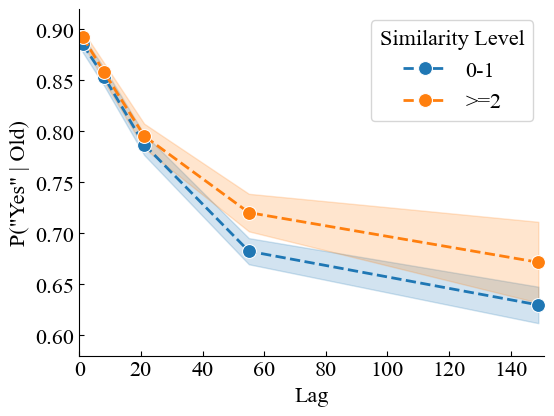

In [25]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='hr', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='--', lw=2, ax=ax, errorbar='se')
plt.ylabel('P("Yes" | Old)')
plt.xlabel('Lag')
# ax.set(xlabel=None, ylabel=None)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
plt.ylim([0.58,0.92])
plt.xlim([0,151])
# legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='--',label = 'Low'),
#                    Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='--', label = 'High')]
# plt.legend(handles = legend_elements, title = "Similarity Level")
plt.legend(title = "Similarity Level")

if SAVEFIG:
    plt.savefig(f'simu1_fig/simu1_David_hr_{option}.pdf')

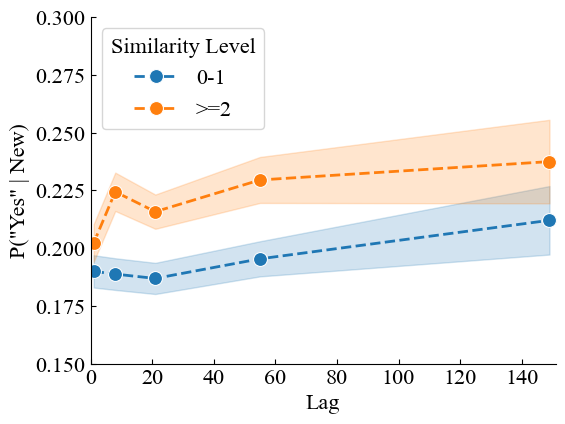

In [26]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='far', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='--', lw=2, ax=ax, errorbar='se')
plt.ylabel('P("Yes" | New)')
plt.xlabel('Lag')
# ax.set(xlabel=None, ylabel=None)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
plt.ylim([0.15,0.30])
plt.xlim([0,151])
# legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='--',label = 'Low'),
#                    Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='--', label = 'High')]
# plt.legend(handles = legend_elements, title = "Similarity Level")
plt.legend(title = "Similarity Level", loc = 'upper left')

if SAVEFIG:
    plt.savefig(f'simu1_fig/simu1_David_far_{option}.pdf')

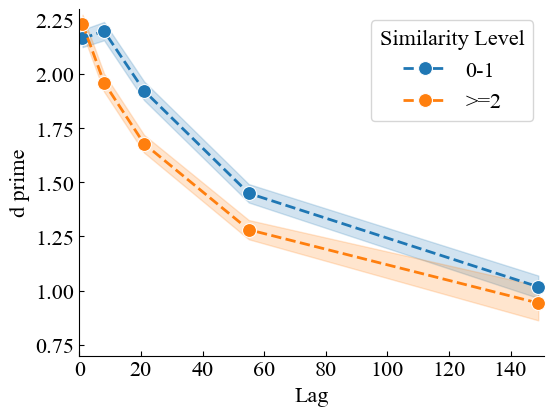

In [27]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_dprime, y='dprime', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='--', lw=2, ax=ax, errorbar='se')
plt.ylabel('d prime')
plt.xlabel('Lag')
# ax.set(xlabel=None, ylabel=None)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
plt.ylim([0.70, 2.30])
plt.xlim([0,151])
# legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='--',label = 'Low'),
#                    Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='--', label = 'High')]
# plt.legend(handles = legend_elements, title = "Similarity Level")
plt.legend(title = "Similarity Level")

if SAVEFIG:
    plt.savefig(f'simu1_fig/simu1_David_dprime_{option}.pdf')

In [28]:
df_hrfar = df_dprime.groupby(['roll_cat_len_level', 'log_lag_disp'])[['hr', 'far']].mean().reset_index()
hr_lowsim = df_hrfar.query('roll_cat_len_level == "0-1"').hr.to_numpy()
hr_highsim = df_hrfar.query('roll_cat_len_level == ">=2"').hr.to_numpy()
far_lowsim = df_hrfar.query('roll_cat_len_level == "0-1"').far.to_numpy()
far_highsim = df_hrfar.query('roll_cat_len_level == ">=2"').far.to_numpy()
hr_lowsim, hr_highsim, far_lowsim, far_highsim

(array([0.88563614, 0.85351437, 0.78708539, 0.68241696, 0.62969583]),
 array([0.89278445, 0.85808538, 0.79548588, 0.72031362, 0.67155172]),
 array([0.18991605, 0.18873612, 0.18686025, 0.19534963, 0.21202367]),
 array([0.20222126, 0.2243676 , 0.21575807, 0.22949028, 0.23744355]))

### Az

In [29]:
def calculate_Az(df_tmp1):
    log_lag_bins = [0, 2, 3, 4, 5]
    Azs = []
    for bin in log_lag_bins:

        # get the df of this log_lag_bin
        col_name = "log_lag_bin_" + str(bin)
        df_tmp = df_tmp1.query(col_name + " == True").copy()

        # get variables
        conf = df_tmp.confidence.to_numpy()
        truth = df_tmp.old.to_numpy()
        old_num = np.sum(truth)
        new_num = np.sum(~truth)
        is_old = truth
        is_new = ~truth

        if old_num == 0 or new_num == 0:
            Azs.append(np.nan)
            continue
        
        min_conf = np.nanmin(conf)
        max_conf = np.nanmax(conf)

        if max_conf == min_conf:  ### need consider!
            Azs.append(np.nan)
            continue

        # calculate HR and FAR for different thresholds
        # thresholds = np.arange(1,8)
        thresholds = np.arange(min_conf, max_conf+1)
        hrs = []
        fars = []
        old_conf = conf * is_old
        new_conf = conf * is_new
        for thresh in thresholds:
            # hr = (np.sum((conf > thresh) & is_old) + 0.5) / (old_num + 1)
            # far = (np.sum((conf > thresh) & is_new) + 0.5) / (new_num + 1)
            hr = (np.sum(old_conf > thresh) + 0.5) / (old_num + 1)
            far = (np.sum(new_conf > thresh) + 0.5) / (new_num + 1)
            hrs.append(hr)
            fars.append(far)

        # calculate z_hr and z_far
        z_hr = norm.ppf(hrs)
        z_far = norm.ppf(fars)

        # # linear regression on z_hr and z_far using sklearn
        # X = np.array(z_far).reshape(-1, 1)
        # y = np.array(z_hr)
        # reg = LinearRegression().fit(X, y)
        # # get slope and intercept 
        # slope = reg.coef_[0]
        # intercept = reg.intercept_

        # linear regression on z_hr and z_far manually
        try:
            n = len(z_far)
            X = np.column_stack((np.ones(n), z_far))
            beta = np.linalg.inv(X.T @ X) @ X.T @ z_hr
            intercept, slope = beta
        except:
            Azs.append(np.nan)
            continue

        # get A_z
        Az = norm.cdf(intercept/np.sqrt(1+slope**2))
        Azs.append(Az)
    
    # df to return
    df_return = pd.DataFrame({'log_lag_bin': log_lag_bins, 'Az': Azs})

    return df_return

In [30]:
df_Az = df.groupby(["subject_ID", "roll_cat_len_level"]).apply(calculate_Az).reset_index()
df_Az.drop(columns = 'level_2', inplace = True)
df_Az['log_lag_disp'] = np.ceil(np.e**df_Az.log_lag_bin)
df_Az

/var/folders/js/fb9kwys10ln8jgq1bxxqg0tr0000gn/T/ipykernel_1422/1320229888.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_Az = df.groupby(["subject_ID", "roll_cat_len_level"]).apply(calculate_Az).reset_index()


,subject_ID,roll_cat_len_level,log_lag_bin,Az,log_lag_disp
0,0,0-1,0,0.941318,1.0
1,0,0-1,2,0.907703,8.0
2,0,0-1,3,0.880913,21.0
3,0,0-1,4,0.911735,55.0
4,0,0-1,5,NaN,149.0
...,...,...,...,...,...
3505,656,>=2,0,0.892535,1.0
3506,656,>=2,2,0.834377,8.0
3507,656,>=2,3,0.846041,21.0
3508,656,>=2,4,0.767538,55.0


In [31]:
# df_Az = df.groupby(["subject_ID", "roll_cat_len_level"]).apply(calculate_Az).to_frame(name="Az").reset_index()
# df_Az['log_lag_disp'] = np.ceil(np.e**df_Az.log_lag_bin)
# df_Az

In [32]:
# pickup those rows where Az is Nan in df_Az
df_Az.loc[df_Az.Az.isna()]

,subject_ID,roll_cat_len_level,log_lag_bin,Az,log_lag_disp
4,0,0-1,5,NaN,149.0
8,0,>=2,4,NaN,55.0
9,0,>=2,5,NaN,149.0
19,1,>=2,5,NaN,149.0
29,2,>=2,5,NaN,149.0
...,...,...,...,...,...
3448,645,>=2,4,NaN,55.0
3459,646,>=2,5,NaN,149.0
3469,651,>=2,5,NaN,149.0
3479,653,>=2,5,NaN,149.0


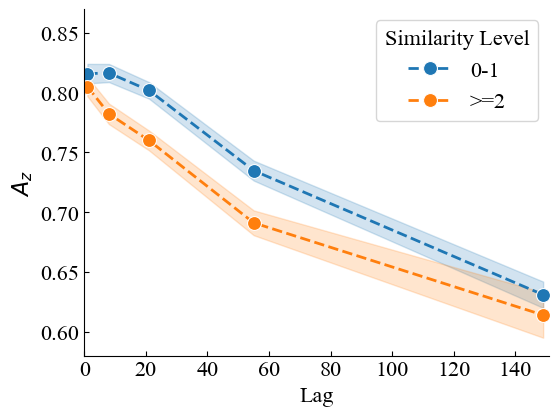

In [33]:
fig, ax = plt.subplots(figsize=(6,4.5))
# fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.98)

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
sns.lineplot(data=df_Az, y='Az', x='log_lag_disp', hue = 'roll_cat_len_level', marker = 'o', markersize = 10, linestyle='--', lw=2, ax=ax, errorbar='se')
plt.ylabel('$A_z$')
plt.xlabel('Lag')
# ax.set(xlabel=None, ylabel=None)
# selected_lag = np.array([1,np.e,np.e**2,np.e**3,np.e**4,np.e**5])
# plt.xticks(ticks=selected_lag, labels = ['1','e','e2','e3','e4','e5'])
plt.xticks(ticks=np.arange(0,160,20))
plt.ylim([0.58, 0.87])
plt.xlim([0,151])
# legend_elements = [Line2D([0], [0], color = sns.color_palette()[0], lw=2, marker='o', markersize = 10, linestyle='--',label = 'Low'),
#                    Line2D([0], [0], color = sns.color_palette()[1], lw=2, marker='o', markersize = 10, linestyle='--', label = 'High')]
# plt.legend(handles = legend_elements, title = "Similarity Level")
plt.legend(title = "Similarity Level")

if SAVEFIG:
    plt.savefig(f'simu1_fig/simu1_David_Az_{option}.pdf')

In [34]:
df_plot = df_Az.groupby(["roll_cat_len_level", "log_lag_bin"]).Az.mean().to_frame(name="Az").reset_index()
Az_lowsim = df_plot.query("roll_cat_len_level == '0-1'").Az.to_numpy()
Az_highsim = df_plot.query("roll_cat_len_level == '>=2'").Az.to_numpy()
Az_lowsim, Az_highsim

(array([0.8159747 , 0.81648819, 0.80197411, 0.7348207 , 0.63092786]),
 array([0.8051513 , 0.78230925, 0.76005653, 0.69112946, 0.61392629]))